In [505]:
import gmsh
import meshio
import numpy
import pygmsh
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subprocess
import csv

# Initialize Circles in 2D Domain (X, Y)

In [506]:
resolution = 0.01
Lx = 10
Ly = 10
radius = 0.90
point0 = (0, 0, 0)
point1 = (Lx, 0, 0)
point2 = (Lx, Ly, 0)
point3 = (0, Ly, 0)

centers = [
           (1, 1, 0),
           (3, 1, 0),
           (5, 1, 0),
           (7, 1, 0),
           (9, 1, 0),
           (2, 2.5, 0),
           (4, 2.5, 0),
           (6, 2.5, 0),
           (8, 2.5, 0),
           (1, 4.10, 0),
           (3, 4.10, 0),
           (5, 4.10, 0),
           (7, 4.10, 0),
           (9, 4.10, 0),
           (1, 6, 0),
           (3, 6, 0),
           (5, 6, 0),
           (7, 6, 0),
           (9, 6, 0),
           (2, 7.5, 0),
           (4, 7.5, 0),
           (6, 7.5, 0),
           (8, 7.5, 0),
           (1, 9.10, 0),
           (3, 9.10, 0),
           (5, 9.10, 0),
           (7, 9.10, 0),
           (9, 9.10, 0),

]
r = radius

# Generate Mesh

In [507]:
geometry = pygmsh.geo.Geometry()
model = geometry.__enter__()

In [508]:
points = [model.add_point(point0, mesh_size=resolution),
          model.add_point(point1, mesh_size=resolution),
          model.add_point(point2, mesh_size=resolution),
          model.add_point(point3, mesh_size=resolution),
          ]

In [509]:
channel_lines = [model.add_line(points[i], points[i+1])
  for i in range(-1, len(points)-1)]
channel_loop = model.add_curve_loop(channel_lines)
circles = [model.add_circle(c, r, mesh_size=resolution) for c in centers]
holes = [circle.curve_loop for circle in circles]
plane_surface = model.add_plane_surface(channel_loop, holes=holes)
model.synchronize()

In [510]:
volume_marker = 6
model.add_physical([plane_surface], "Volume")
model.add_physical([channel_lines[0]], "Left")
model.add_physical([channel_lines[2]], "Right")
model.add_physical([channel_lines[1], channel_lines[3]], "Insulated")
for i, c in enumerate(circles):
    model.add_physical(c.curve_loop.curves, "void%d" % i)

In [511]:
geometry.generate_mesh(dim=2)
gmsh.write("mesh.msh")
gmsh.clear()
geometry.__exit__()

In [512]:
mesh_from_file = meshio.read("mesh.msh")

In [513]:
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

In [514]:
line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write("facet_mesh.xdmf", line_mesh)

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("mesh.xdmf", triangle_mesh)


# Run Fenics Model

In [515]:
cmd = 'mpirun -n 2 python3 demo_poisson.py'
!{cmd}

done loading triangular mesh
done loading triangular mesh


In [516]:
# load simulation results
with h5py.File("poisson.h5", 'r') as hf:
    values = hf.get("Function/f_4/0")[:]
    positions = hf.get("Mesh/Grid/geometry")[:]

positions = np.around(positions, 2)
results = np.hstack((positions, values))

In [517]:
idx = np.lexsort((results[:, 0], results[:, 1]))
results = results[idx]
results = pd.DataFrame(results, columns=['x', 'y', 'u'])
results = results.groupby(['x', 'y']).mean('u')
results.reset_index(inplace=True)
results.head(5)
results = results.to_numpy()

In [518]:

x_series = np.arange(0, Lx + resolution, resolution)
y_series = np.arange(0, Ly + resolution, resolution)

grad_data = np.zeros(results.shape)
avg_cond = []
for y_val in y_series:
    results_slice = results[np.where(np.isclose(results[:, 1], y_val))]
    results_slice = results_slice[np.argsort(results_slice[:, 0])]
    x_vals = results_slice[:, 0] / Lx
    u_vals = results_slice[:, 2]
    grad = -np.divide(u_vals[1:] - u_vals[:-1], x_vals[1:] - x_vals[:-1])
    avg_cond.append(np.average(grad))
porosity = 1 - len(centers) * np.pi * (radius ** 2) / (Lx * Ly)

# Visualize Results

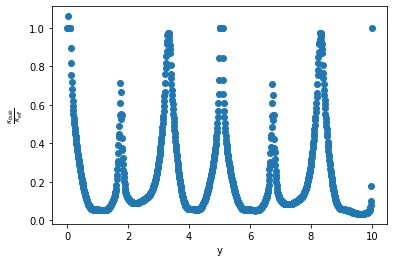

{'Lx': 10,
 'Ly': 10,
 'radius': 0.9,
 'n spheres': 28,
 'porosity': 0.2874867861658349,
 'model eff. conductivity': 0.2273267621119573,
 'bruggeman eff. conductivity': 0.15414407354048432}

In [519]:
plt.scatter(y_series, avg_cond)
plt.xlabel(r'y')
plt.ylabel(r'$\frac{\kappa_{bulk}}{\kappa_{eff}}$')
plt.show()
results_summary = {
    'Lx': Lx,
    'Ly': Ly,
    'radius': radius,
    'n spheres': len(centers),
    "porosity": porosity,
    "model eff. conductivity": np.average(avg_cond),
    "bruggeman eff. conductivity": porosity ** 1.5
}
with open("results-summary.txt", "a+") as fp:
    writer = csv.DictWriter(fp, fieldnames=['Lx', 'Ly', 'radius', 'n spheres','porosity', 'model eff. conductivity', 'bruggeman eff. conductivity'])
    writer.writerow(results_summary)
results_summary